# **Predicción del Movimiento de Nubes para la Optimización de Plantas Fotovoltaicas en Colombia**

## 1) Descarga de imágenes

A continuación se muestra el código empleado para la descarga de imágenes correspondientes a la banda 13 para el periodo de tiempo comprendido entre el 01/01/2024 y el 31/12/2024. Ingresar al siguiente repositorio de github: https://github.com/alwos19/monografia_esp_cd

## 2) Obtención del dataset

A partir de las imagenes obtenidas se realiza la construcción de una dataset en el que las columnas correspondan a cada hora del día y las filas a cada día del año, dentro de cada celda se ubica la imagen correspondiente con una tamaño de 920X920, el valor de cada pixel corresponde a los valores de radiancia para le día y la hora correspondientes.

In [12]:
# Librerias de utilidad
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# Ruta donde están almacenados los archivos .npy
ruta_archivos = "./rad13"  # Cambia esto por la ruta real
archivos = os.listdir(ruta_archivos)

# Función para procesar un archivo individual (sin guardar la matriz radiancia)
def procesar_archivo(archivo):
    if archivo.endswith(".npy") and archivo.startswith("RadFC_"):
        try:
            nombre = archivo.replace("RadFC_", "").replace("_Rad13.npy", "")
            fecha_str = nombre[:12]  # 'YYYYMMDDHHMM'
            fecha_datetime = datetime.strptime(fecha_str, "%Y%m%d%H%M")
            fecha = fecha_datetime
            mes = fecha_datetime.month
            hora = fecha_datetime.strftime("%H:%M")
            hora_num = fecha_datetime.hour
            ruta_completa = os.path.join(ruta_archivos, archivo)
            radiancia = np.load(ruta_completa).astype(np.float32)
            if radiancia.shape == (920, 920):
                return {
                    "fecha": fecha,
                    "mes": mes,
                    "hora": hora,
                    "hora_num": hora_num,
                    "archivo": archivo,
                    "media": np.mean(radiancia),
                    "varianza": np.var(radiancia),
                    "desviacion_estandar": np.std(radiancia),
                    "minimo": np.min(radiancia),
                    "maximo": np.max(radiancia),
                    "mediana": np.median(radiancia),
                }
            else:
                print(f"Dimensiones incorrectas en: {archivo}")
        except Exception as e:
            print(f"Error procesando {archivo}: {e}")
    return None

# Procesar todos los archivos y guardar los resultados válidos
datos = []
for archivo in archivos:
    resultado = procesar_archivo(archivo)
    if resultado is not None:
        datos.append(resultado)

# Crear el DataFrame y establecer 'fecha' como índice
df_imagenes = pd.DataFrame(datos)
df_imagenes["fecha"] = pd.to_datetime(df_imagenes["fecha"])
df_imagenes = df_imagenes.set_index("fecha")
df_imagenes.sort_index(inplace=True)

# Mostrar las primeras filas para verificar
print(df_imagenes.head())

                     mes   hora  hora_num                         archivo  \
fecha                                                                       
2024-01-01 00:00:00    1  00:00         0  RadFC_20240101000020_Rad13.npy   
2024-01-01 01:00:00    1  01:00         1  RadFC_20240101010020_Rad13.npy   
2024-01-01 02:00:00    1  02:00         2  RadFC_20240101020020_Rad13.npy   
2024-01-01 03:00:00    1  03:00         3  RadFC_20240101030020_Rad13.npy   
2024-01-01 04:00:00    1  04:00         4  RadFC_20240101040020_Rad13.npy   

                         media    varianza  desviacion_estandar    minimo  \
fecha                                                                       
2024-01-01 00:00:00  75.832336  614.352234            24.786129  7.227110   
2024-01-01 01:00:00  75.948067  559.567871            23.655188  8.690435   
2024-01-01 02:00:00  75.844902  507.472351            22.527147  8.324604   
2024-01-01 03:00:00  75.947083  460.890533            21.468361  7.318568  

In [9]:
df_imagenes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8744 entries, 2024-01-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hora                 8744 non-null   object 
 1   archivo              8744 non-null   object 
 2   media                8744 non-null   float32
 3   varianza             8744 non-null   float32
 4   desviacion_estandar  8744 non-null   float32
 5   minimo               8744 non-null   float32
 6   maximo               8744 non-null   float32
 7   mediana              8744 non-null   float32
dtypes: float32(6), object(2)
memory usage: 409.9+ KB


## 3) Analisis Exploratorio 

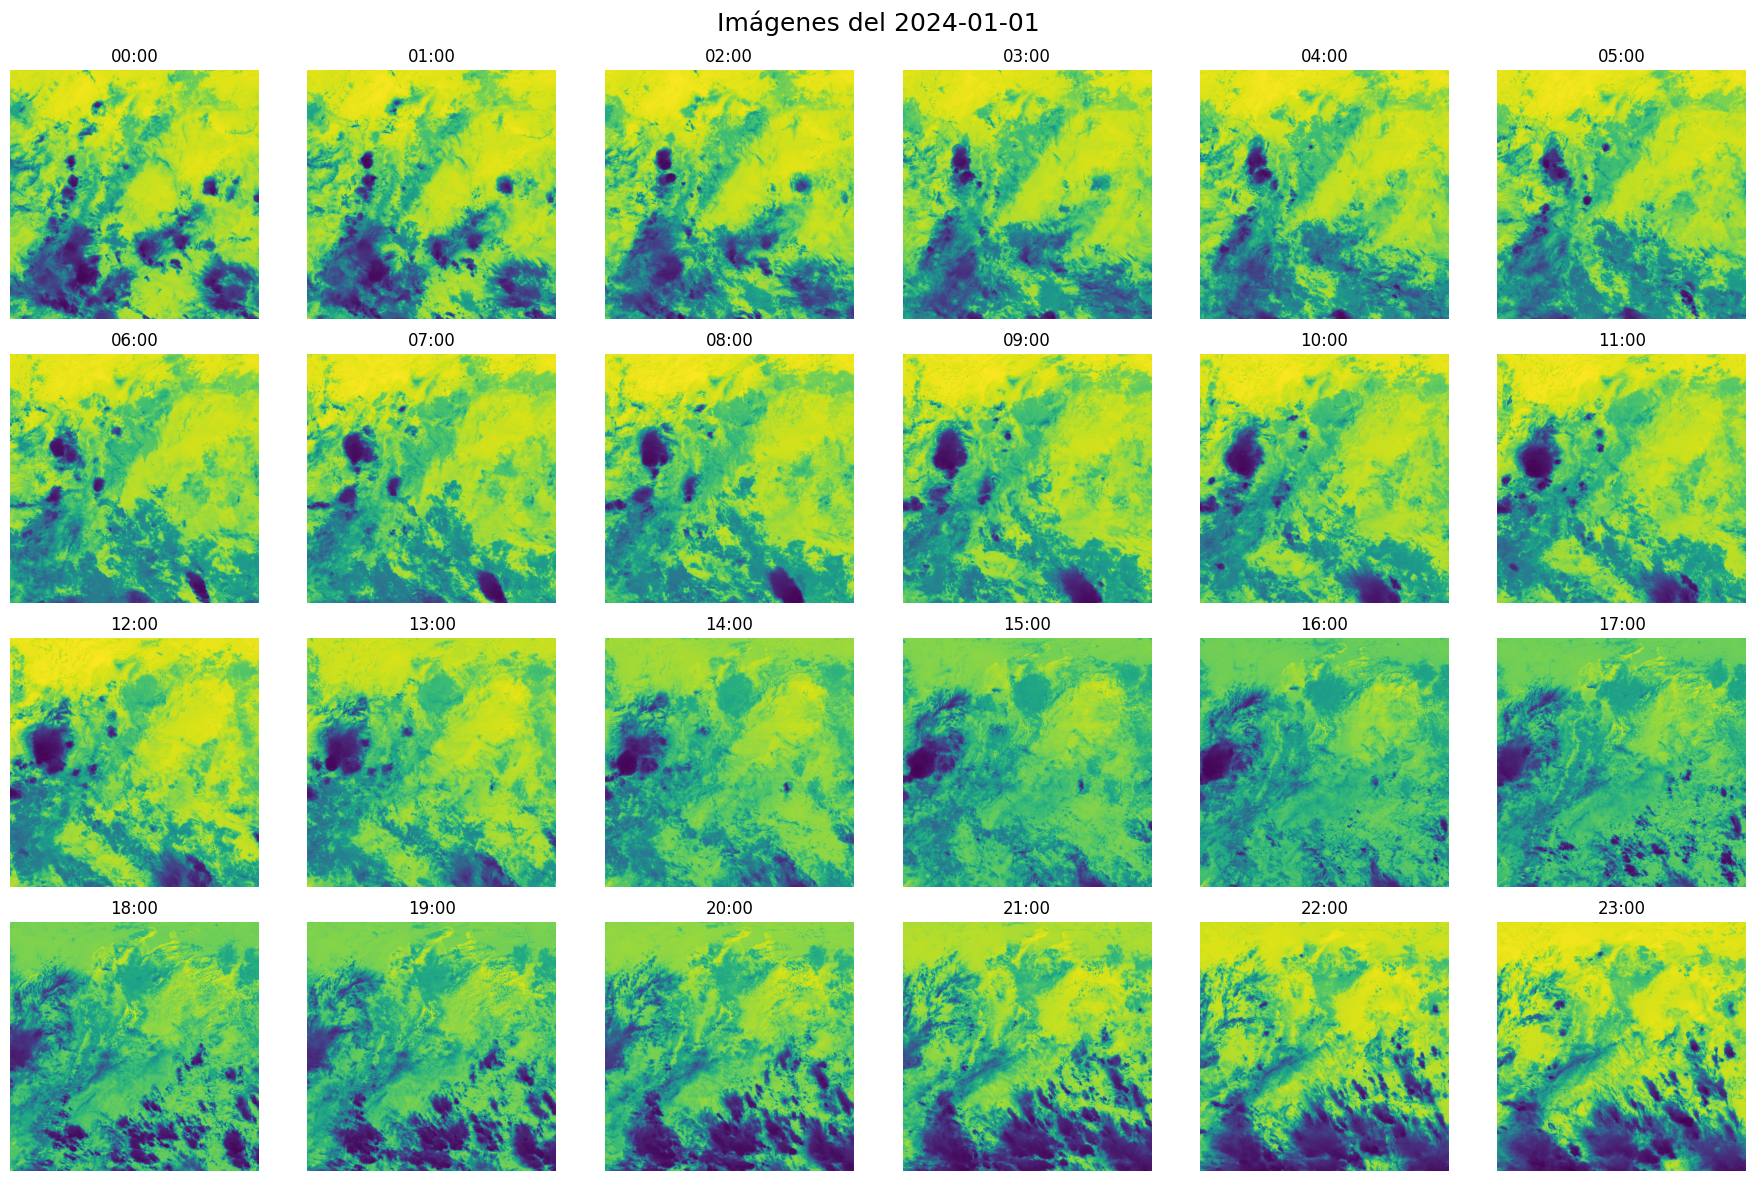

In [21]:
# Día que quieres visualizar (formato: 'YYYY-MM-DD')
dia_especifico = "2024-01-01"

# Filtrar el DataFrame por el día
df_dia = df_imagenes[df_imagenes.index.date == pd.to_datetime(dia_especifico).date()]

# Asegurar que estén ordenadas por hora
df_dia = df_dia.sort_index()

# Verificar si hay imágenes para ese día
if df_dia.empty:
    print(f"No se encontraron imágenes para el día {dia_especifico}")
else:
    # Crear figura
    fig, axes = plt.subplots(4, 6, figsize=(18, 12))
    axes = axes.flatten()

    for i, (fecha, fila) in enumerate(df_dia.iterrows()):
        if i >= 24:
            break  # Mostrar máximo 24 imágenes
        ruta_completa = os.path.join(ruta_archivos, fila["archivo"])
        radiancia = np.load(ruta_completa)

        ax = axes[i]
        im = ax.imshow(radiancia, cmap='viridis')
        ax.set_title(fecha.strftime('%H:%M'))
        ax.axis('off')

    # Ocultar ejes sobrantes si hay menos de 24
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f'Imágenes del {dia_especifico}', fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

Visualización del minimo de radianza

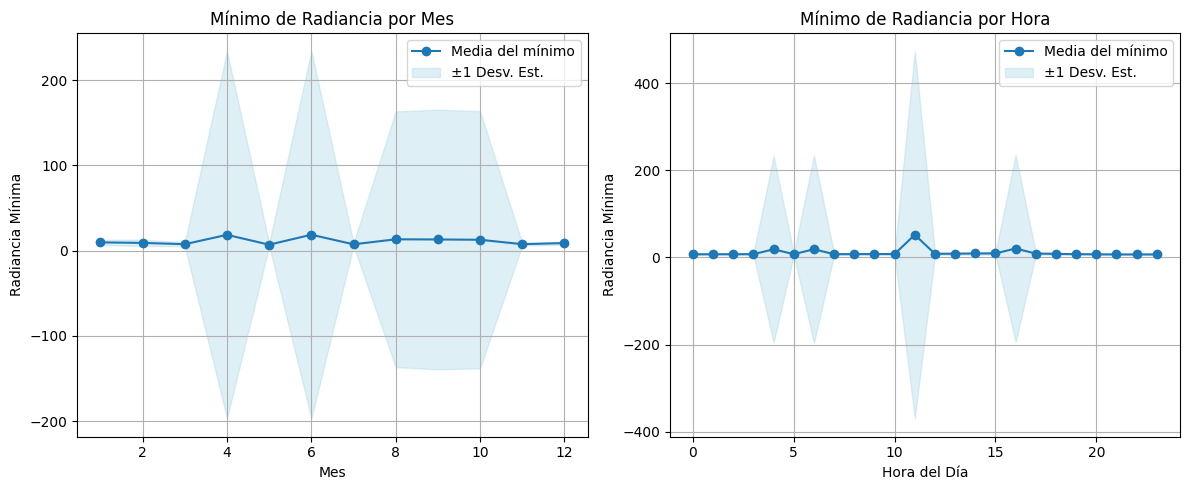

In [ ]:
# ----- RESUMEN POR MES -----
resumen_min_mes = df_imagenes.groupby('mes')['minimo'].agg(['mean', 'std']).reset_index()
resumen_min_mes.rename(columns={'mean': 'media', 'std': 'desviacion_estandar'}, inplace=True)

# ----- RESUMEN POR HORA -----
resumen_min_hora = df_imagenes.groupby('hora_num')['minimo'].agg(['mean', 'std']).reset_index()
resumen_min_hora.rename(columns={'mean': 'media', 'std': 'desviacion_estandar'}, inplace=True)

# ----- GRAFICAR -----
plt.figure(figsize=(12, 5))

# Por mes
plt.subplot(1, 2, 1)
plt.plot(resumen_min_mes['mes'], resumen_min_mes['media'], marker='o', label='Media del mínimo')
plt.fill_between(resumen_min_mes['mes'],
                 resumen_min_mes['media'] - resumen_min_mes['desviacion_estandar'],
                 resumen_min_mes['media'] + resumen_min_mes['desviacion_estandar'],
                 color='lightblue', alpha=0.4, label='±1 Desv. Est.')
plt.title('Mínimo de Radiancia por Mes')
plt.xlabel('Mes')
plt.ylabel('Radiancia Mínima')
plt.legend()
plt.grid(True)

# Por hora
plt.subplot(1, 2, 2)
plt.plot(resumen_min_hora['hora_num'], resumen_min_hora['media'], marker='o', label='Media del mínimo')
plt.fill_between(resumen_min_hora['hora_num'],
                 resumen_min_hora['media'] - resumen_min_hora['desviacion_estandar'],
                 resumen_min_hora['media'] + resumen_min_hora['desviacion_estandar'],
                 color='lightblue', alpha=0.4, label='±1 Desv. Est.')
plt.title('Mínimo de Radiancia por Hora')
plt.xlabel('Hora del Día')
plt.ylabel('Radiancia Mínima')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Visualización por maximo de radiancia

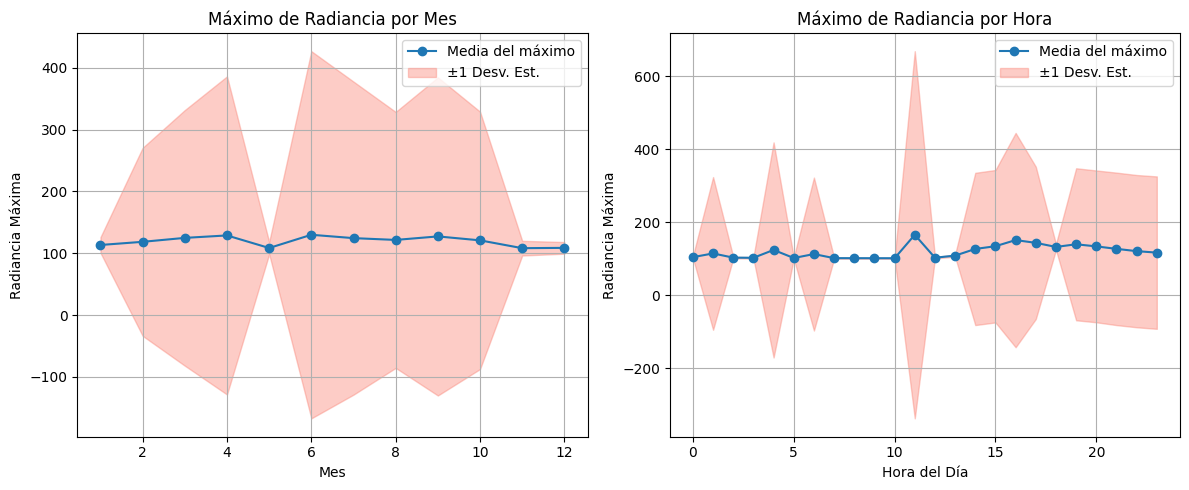

In [25]:
# ----- RESUMEN POR MES -----
resumen_max_mes = df_imagenes.groupby('mes')['maximo'].agg(['mean', 'std']).reset_index()
resumen_max_mes.rename(columns={'mean': 'media', 'std': 'desviacion_estandar'}, inplace=True)

# ----- RESUMEN POR HORA -----
resumen_max_hora = df_imagenes.groupby('hora_num')['maximo'].agg(['mean', 'std']).reset_index()
resumen_max_hora.rename(columns={'mean': 'media', 'std': 'desviacion_estandar'}, inplace=True)

# ----- GRAFICAR -----
plt.figure(figsize=(12, 5))

# Por mes
plt.subplot(1, 2, 1)
plt.plot(resumen_max_mes['mes'], resumen_max_mes['media'], marker='o', label='Media del máximo')
plt.fill_between(resumen_max_mes['mes'],
                 resumen_max_mes['media'] - resumen_max_mes['desviacion_estandar'],
                 resumen_max_mes['media'] + resumen_max_mes['desviacion_estandar'],
                 color='salmon', alpha=0.4, label='±1 Desv. Est.')
plt.title('Máximo de Radiancia por Mes')
plt.xlabel('Mes')
plt.ylabel('Radiancia Máxima')
plt.legend()
plt.grid(True)

# Por hora
plt.subplot(1, 2, 2)
plt.plot(resumen_max_hora['hora_num'], resumen_max_hora['media'], marker='o', label='Media del máximo')
plt.fill_between(resumen_max_hora['hora_num'],
                 resumen_max_hora['media'] - resumen_max_hora['desviacion_estandar'],
                 resumen_max_hora['media'] + resumen_max_hora['desviacion_estandar'],
                 color='salmon', alpha=0.4, label='±1 Desv. Est.')
plt.title('Máximo de Radiancia por Hora')
plt.xlabel('Hora del Día')
plt.ylabel('Radiancia Máxima')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Vusualización por promedio de radianza

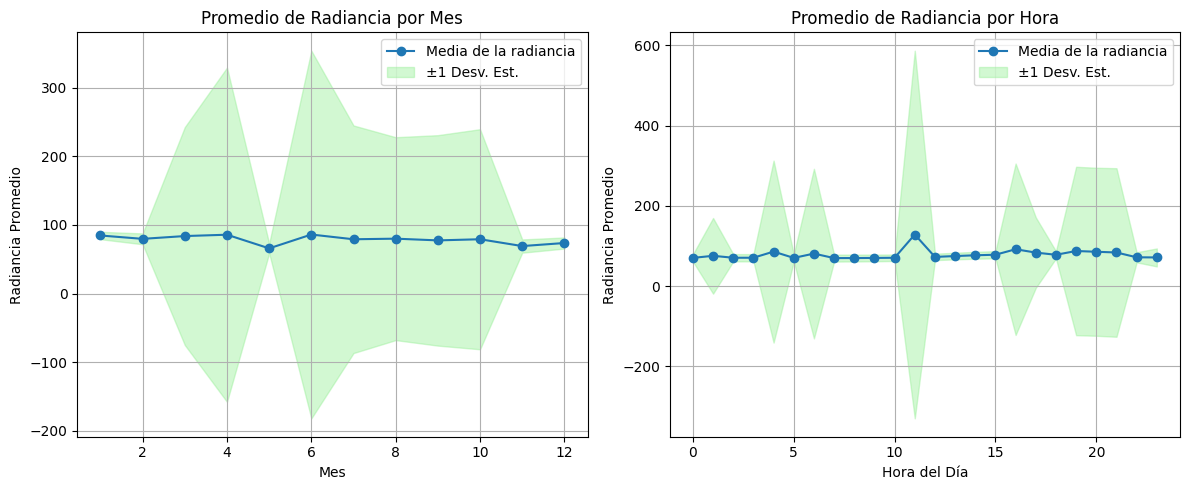

In [26]:
# ----- RESUMEN POR MES -----
resumen_media_mes = df_imagenes.groupby('mes')['media'].agg(['mean', 'std']).reset_index()
resumen_media_mes.rename(columns={'mean': 'media', 'std': 'desviacion_estandar'}, inplace=True)

# ----- RESUMEN POR HORA -----
resumen_media_hora = df_imagenes.groupby('hora_num')['media'].agg(['mean', 'std']).reset_index()
resumen_media_hora.rename(columns={'mean': 'media', 'std': 'desviacion_estandar'}, inplace=True)

# ----- GRAFICAR -----
plt.figure(figsize=(12, 5))

# Por mes
plt.subplot(1, 2, 1)
plt.plot(resumen_media_mes['mes'], resumen_media_mes['media'], marker='o', label='Media de la radiancia')
plt.fill_between(resumen_media_mes['mes'],
                 resumen_media_mes['media'] - resumen_media_mes['desviacion_estandar'],
                 resumen_media_mes['media'] + resumen_media_mes['desviacion_estandar'],
                 color='lightgreen', alpha=0.4, label='±1 Desv. Est.')
plt.title('Promedio de Radiancia por Mes')
plt.xlabel('Mes')
plt.ylabel('Radiancia Promedio')
plt.legend()
plt.grid(True)

# Por hora
plt.subplot(1, 2, 2)
plt.plot(resumen_media_hora['hora_num'], resumen_media_hora['media'], marker='o', label='Media de la radiancia')
plt.fill_between(resumen_media_hora['hora_num'],
                 resumen_media_hora['media'] - resumen_media_hora['desviacion_estandar'],
                 resumen_media_hora['media'] + resumen_media_hora['desviacion_estandar'],
                 color='lightgreen', alpha=0.4, label='±1 Desv. Est.')
plt.title('Promedio de Radiancia por Hora')
plt.xlabel('Hora del Día')
plt.ylabel('Radiancia Promedio')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Mapa de calor

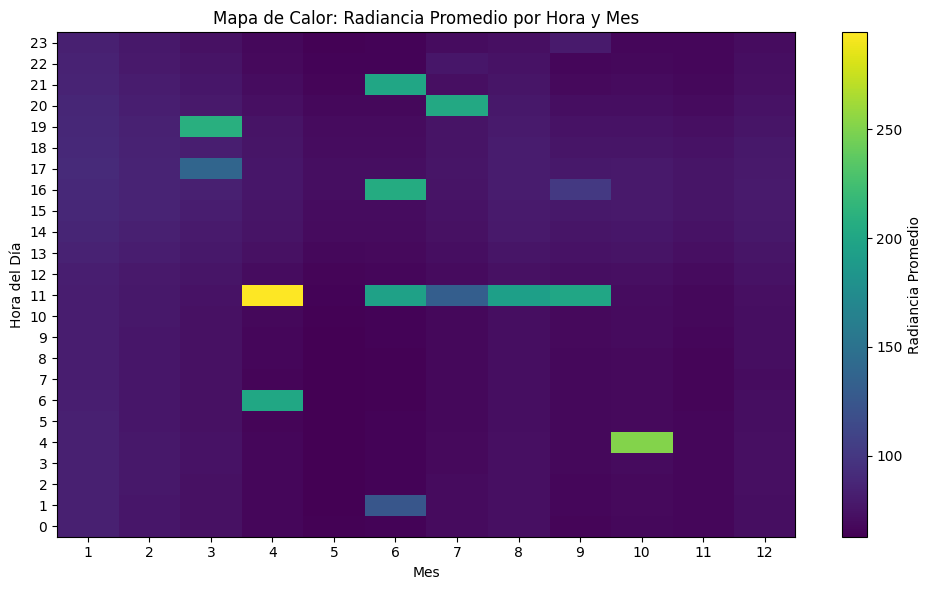

In [28]:
# Crear tabla pivote (hora vs mes)
pivot_heatmap = df_imagenes.pivot_table(
    values='media',
    index='hora_num',
    columns='mes',
    aggfunc='mean'
)

# Heatmap
plt.figure(figsize=(10, 6))
plt.imshow(pivot_heatmap, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Radiancia Promedio')
plt.title('Mapa de Calor: Radiancia Promedio por Hora y Mes')
plt.xlabel('Mes')
plt.ylabel('Hora del Día')
plt.xticks(ticks=np.arange(0, 12), labels=[str(m) for m in range(1, 13)])
plt.yticks(ticks=np.arange(0, 24), labels=[str(h) for h in range(0, 24)])
plt.tight_layout()
plt.show()

Linea temporal de la radiancia promedio

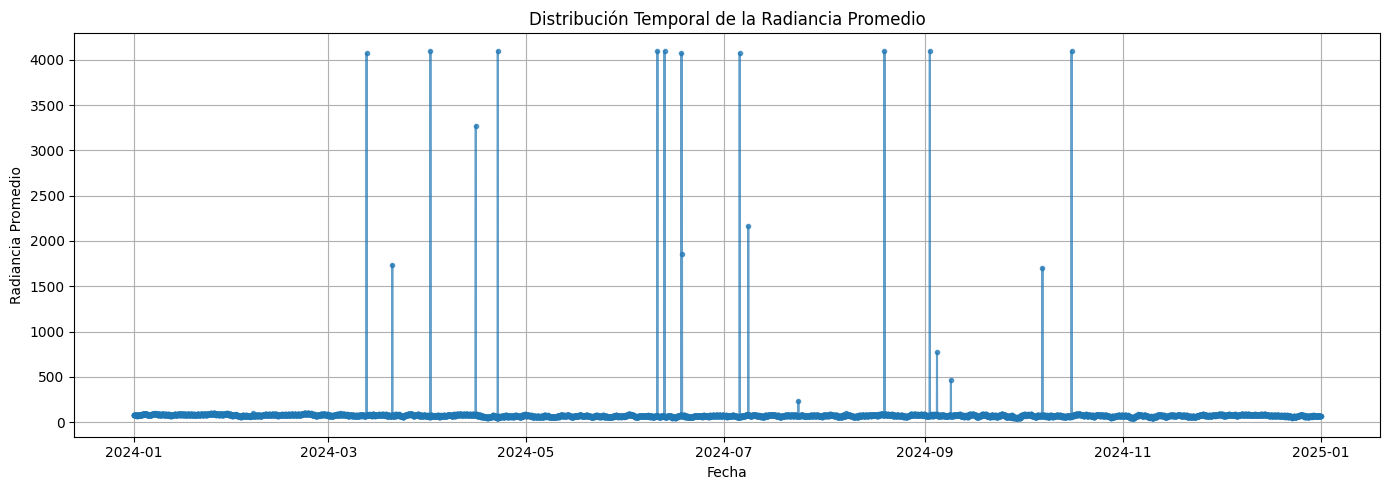

In [31]:
# Línea temporal de radiancia promedio
plt.figure(figsize=(14, 5))
plt.plot(df_imagenes.index, df_imagenes['media'], marker='.', linestyle='-', alpha=0.7)
plt.title('Distribución Temporal de la Radiancia Promedio')
plt.xlabel('Fecha')
plt.ylabel('Radiancia Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()

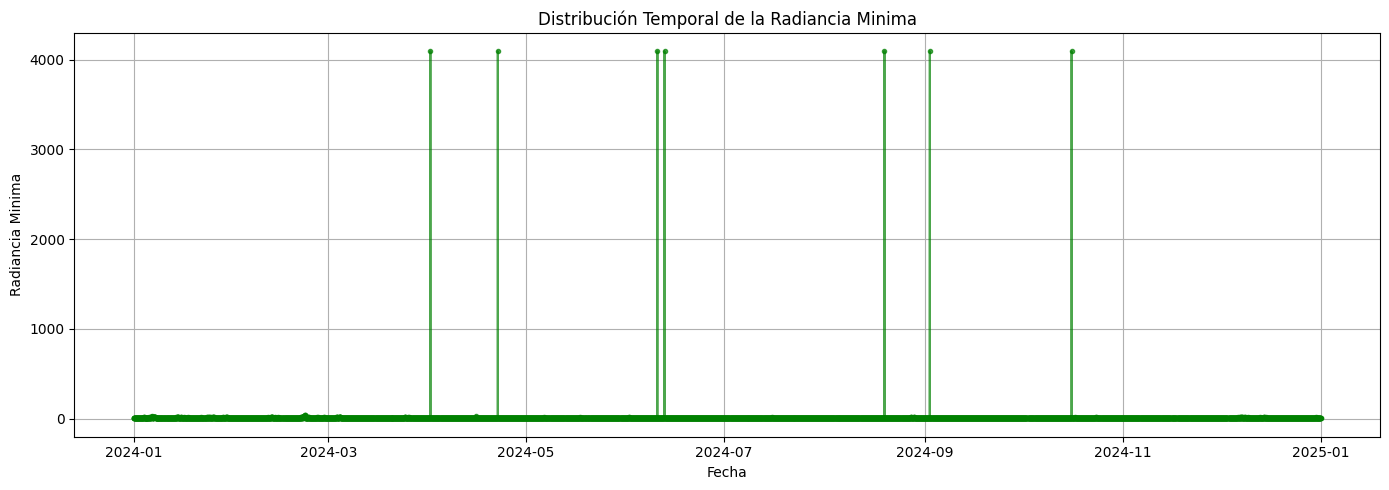

In [38]:
# Línea temporal de radiancia minima
plt.figure(figsize=(14, 5))
plt.plot(df_imagenes.index, df_imagenes['minimo'], marker='.', linestyle='-', alpha=0.7, color='green')
plt.title('Distribución Temporal de la Radiancia Minima')
plt.xlabel('Fecha')
plt.ylabel('Radiancia Minima')
plt.grid(True)
plt.tight_layout()
plt.show()

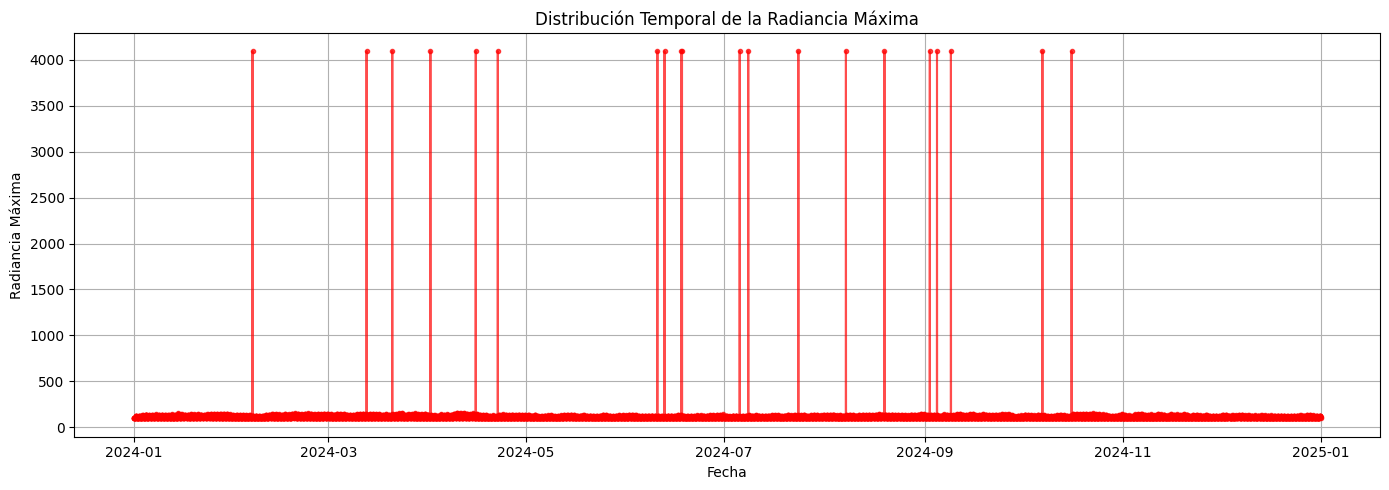

In [37]:
# Línea temporal de radiancia Máxima
plt.figure(figsize=(14, 5))
plt.plot(df_imagenes.index, df_imagenes['maximo'], marker='.', linestyle='-', alpha=0.7, color='red')
plt.title('Distribución Temporal de la Radiancia Máxima')
plt.xlabel('Fecha')
plt.ylabel('Radiancia Máxima')
plt.grid(True)
plt.tight_layout()
plt.show()

Identificación de Outliers

In [39]:
# Función para detectar outliers en una matriz 2D desde archivo .npy
def detectar_outliers_archivo(ruta):
    matriz = np.load(ruta)
    flat = matriz.flatten()
    q1 = np.percentile(flat, 25)
    q3 = np.percentile(flat, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers_mask = (flat < lower) | (flat > upper)
    num_outliers = np.sum(outliers_mask)
    return num_outliers, outliers_mask.reshape((920, 920))

# Aplica la función a cada archivo y guarda los resultados en nuevas columnas
df_imagenes[['num_outliers', 'outliers_mask']] = df_imagenes['archivo'].apply(
    lambda nombre: pd.Series(detectar_outliers_archivo(os.path.join(ruta_archivos, nombre)))
)

# Ejemplo: mostrar los primeros resultados
print(df_imagenes[['archivo', 'num_outliers']].head())

                                            archivo  num_outliers
fecha                                                            
2024-01-01 00:00:00  RadFC_20240101000020_Rad13.npy         30103
2024-01-01 01:00:00  RadFC_20240101010020_Rad13.npy         16313
2024-01-01 02:00:00  RadFC_20240101020020_Rad13.npy          5149
2024-01-01 03:00:00  RadFC_20240101030020_Rad13.npy          2803
2024-01-01 04:00:00  RadFC_20240101040020_Rad13.npy          4694


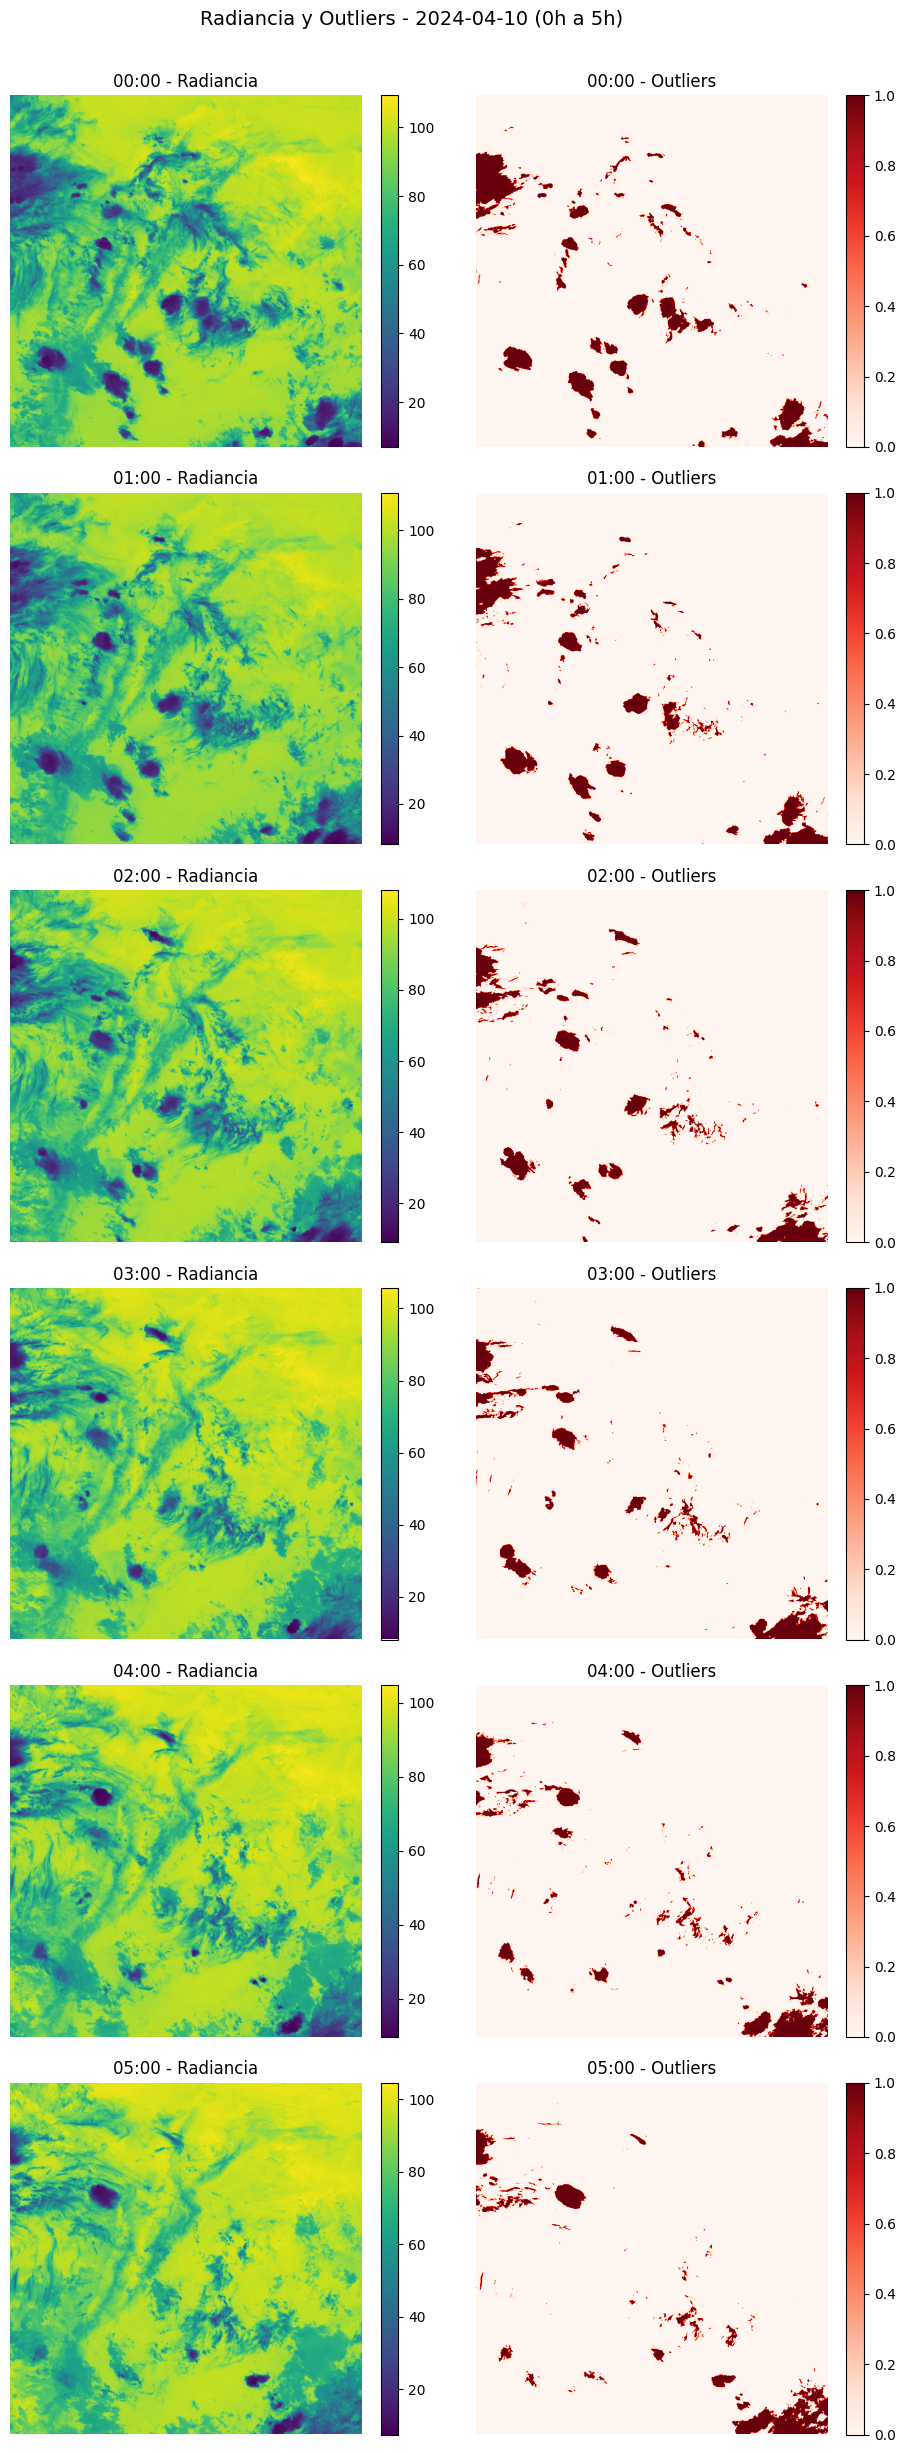

In [57]:
# Día a visualizar (puedes cambiar esta fecha)
fecha_objetivo = '2024-04-10'

# Filtrar las imágenes de ese día y entre las primeras 6 horas (0 a 5)
imagenes_dia = df_imagenes.loc[fecha_objetivo]
imagenes_6h = imagenes_dia[imagenes_dia.index.hour < 6].sort_index()

# Asegurar que hay imágenes disponibles
if imagenes_6h.empty:
    print(f"No se encontraron imágenes para las primeras 6 horas del {fecha_objetivo}")
else:
    n = len(imagenes_6h)
    plt.figure(figsize=(10, 4 * n))

    for i, (index, fila) in enumerate(imagenes_6h.iterrows()):
        ruta = os.path.join(ruta_archivos, fila['archivo'])
        radiancia = np.load(ruta)
        outliers_mask = fila['outliers_mask']

        # Radiancia
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(radiancia, cmap='viridis')
        plt.title(f"{index.strftime('%H:%M')} - Radiancia")
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)

        # Outliers
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(outliers_mask, cmap='Reds')
        plt.title(f"{index.strftime('%H:%M')} - Outliers")
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.suptitle(f"Radiancia y Outliers - {fecha_objetivo} (0h a 5h)", fontsize=14, y=1.02)
    plt.show()

Analisis de serie de tiempo